In [2]:
# ! pip install "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

# 'COLAB_TPU_ADDR' in os.environ, 'google.colab' in str(get_ipython())

# import jax
# jax.devices()

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

%cd /content/gdrive/MyDrive/Projects/lensing-minimal/notebooks

! pip install einops scikit-image
! pip install git+https://github.com/adam-coogan/jaxinterp2d.git@master
! pip install flax numpyro distrax corner

Mounted at /content/gdrive
/content/gdrive/MyDrive/Projects/lensing-minimal/notebooks
  Cloning https://github.com/adam-coogan/jaxinterp2d.git (to revision master) to /tmp/pip-req-build-unfbpj5m
  Running command git clone -q https://github.com/adam-coogan/jaxinterp2d.git /tmp/pip-req-build-unfbpj5m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for jaxinterp2d: filename=jaxinterp2d-0.0.1-py3-none-any.whl size=4052 sha256=d649c09e37eccb9fea465f4fde9fabdb79d2a84cabed45f3ba20a3436450a9a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-7qcni3ya/wheels/e4/2c/1b/c2888fc42d56cc5fea09e9b09ed354d983e2820436d65d7856
Successfully built jaxinterp2d
     |████████████████████████████████| 186 kB 5.8 MB/s 
     |████████████████████████████████| 283 kB 45.6 MB/s 
     |████████████████████████████████| 272 kB 32.0 MB/s 
     |████████████████████████████████| 140 kB 46.2 MB/s 
     |████████████████████

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from einops import rearrange

In [6]:
# import matplotlib.pylab as pylab
# import warnings
# import matplotlib.cbook

# from plot_params import params

# warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# pylab.rcParams.update(params)
# cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
from jax.config import config
# config.update("jax_enable_x64", True)

In [8]:
import sys
sys.path.append("../")
from lensing_sim.lensing import LensingSim

In [9]:
cmap = 'magma'

## Observational parameters

In [10]:
# Don't worry about these
exposure = 1610.0
n_xy = 256
pixel_size = 0.1 * 64 / n_xy
mag_zero=25.5
mag_iso=310.5
mag_s = 26.5
fwhm_psf = 0.18

coordinate_limit = pixel_size * n_xy / 2.0
f_iso = LensingSim._mag_to_flux(mag_iso, mag_zero)
S_tot = LensingSim._mag_to_flux(mag_s, mag_zero)

observation_dict = {
    "n_x": n_xy,
    "n_y": n_xy,
    "theta_x_lims": (-coordinate_limit, coordinate_limit),
    "theta_y_lims": (-coordinate_limit, coordinate_limit),
    "exposure": exposure,
    "f_iso": f_iso,
}

### Can play around with changing these ###

# Size of source
theta_s_e = 0.8

# Redshift (distance) of source and lens
global_dict = {"z_s": 1., "z_l": 0.2}

# theta_x_0 and theta_y_0 are the position of lens, theta_E is its size, q is its ellipticity
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.12, "theta_y_0": -0.2, "theta_E": 2.15, "q": 0.8}

###########################################

src_param_dict = {"profile": "Sersic", "theta_x_0": 0., "theta_y_0": 0., "S_tot": S_tot, "theta_e": theta_s_e,"n_srsc": 1}    

## Hoag's object

In [11]:
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
from urllib import request

In [12]:
request.urlretrieve("https://cdn.spacetelescope.org/archives/images/thumb700x/opo0221a.jpg", "hoag.jpg")

('hoag.jpg', <http.client.HTTPMessage at 0x7fa52f2c0810>)

In [13]:
im_source = np.asarray(Image.open('hoag.jpg').convert('L'))

In [14]:
im_source = resize(im_source, (n_xy, n_xy), anti_aliasing=True)

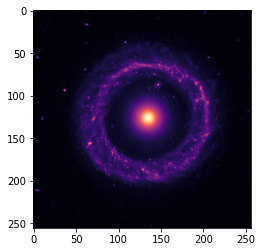

In [15]:
plt.imshow(im_source, cmap=cmap)

## NGC4414

In [16]:
galaxy_url = "https://cdn.spacetelescope.org/archives/images/screen/potw2015a.jpg"
galaxy_name = "NGC2906"

# galaxy_url = "https://cdn.spacetelescope.org/archives/images/screen/opo1036a.jpg"
# galaxy_name = "NGC3982"

In [17]:
request.urlretrieve(galaxy_url, "{}.jpg".format(galaxy_name))
im_source = np.asarray(Image.open("{}.jpg".format(galaxy_name)).convert('L'))
im_source = im_source - np.min(im_source)
im_source = im_source / np.max(im_source)
im_source = np.pad(im_source, (256, 256))
# im_source[im_source < 0.15 * np.max(im_source)] = 0.
# im_source = im_source[:,int((im_source.shape[1] + im_source.shape[0]) / 2):-int((im_source.shape[1] + im_source.shape[0]) / 2)]
im_source = resize(im_source, (n_xy, n_xy), anti_aliasing=True)
# plt.imshow(im_source , cmap=cmap)

In [18]:
# # Lensed image

# lens_list = [hst_param_dict]
        
# lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
# image = lsi.lensed_image()

# plt.imshow(image)

In [19]:
std_noise = 0.02

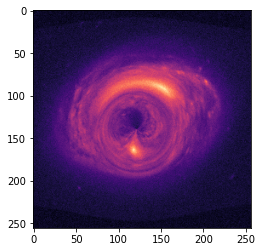

In [20]:
# Change the lens position

src_param_dict = {"profile": "CartesianGrid", "src_ary": im_source} 
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.3, "theta_y_0": -0.15, "theta_E": 1.3, "q": 0.7}
# hst_param_dict = {"profile": "SIE", "theta_x_0": -0., "theta_y_0": 0., "theta_E": 3., "q": 0.7}

lens_list = [hst_param_dict]
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image = lsi.lensed_image() 
image += std_noise * np.random.randn(*image.shape)

plt.imshow(image.T, cmap=cmap)

In [21]:
image.T.max()

DeviceArray(0.9854886, dtype=float32)

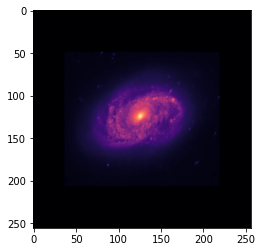

In [22]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image_nolens = jnp.nan_to_num(lsi.lensed_image())

plt.imshow(image_nolens.T, cmap=cmap)

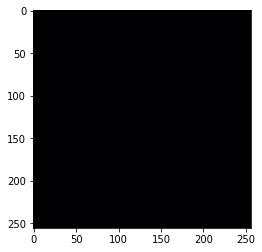

In [23]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [], global_dict, observation_dict)
image_nosrc = lsi.lensed_image()

plt.imshow(image_nosrc, cmap=cmap)

In [24]:
np.mean(image_nolens - image_nosrc), np.std(image_nolens - image_nosrc)

(DeviceArray(0.05183227, dtype=float32),
 DeviceArray(0.09850599, dtype=float32))

## Custom source

In [25]:
import sys
sys.path.append("../")

from lensing_sim.profiles import LightProfileSersic

In [26]:
from jax import vmap, jit
from einops import rearrange, repeat

In [27]:
# Lensed image

def render_lens(inputs):
    
    samples_src, samples_lens_params  = inputs
    theta_E, theta_x, theta_y = samples_lens_params
    
    src_param_dict = {"profile": "CartesianGrid", "src_ary": samples_src}    
    hst_param_dict = {"profile": "SIE", "theta_x_0": theta_x, "theta_y_0": theta_y, "theta_E": theta_E, "q": 0.7}
    
    lens_list = [hst_param_dict]
    
    lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
    image = lsi.lensed_image()
    
    return image


# image = render_lens(inputs)

# plt.imshow(image)

In [28]:
theta_x_lims = theta_y_lims = [-1.5, 1.5]
n_x = n_y = n_xy

theta_x, theta_y = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_x), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_y))

inputs = LightProfileSersic(x_0=0.3, y_0=0., S_tot=5., r_e=1., n_srsc=4,).flux(theta_x, theta_y)

In [29]:
render_lens_vmapped = vmap(jit(render_lens))

## NeRF

In [30]:
def positional_encoding(inputs, positional_encoding_dims=8):
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

In [31]:
from typing import Any

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

In [32]:
num_dense_layers = 4
dense_layer_width = 256
add_positional_encoding = True
add_skip_connection = False

In [33]:
n_lens_params = 3

In [34]:
def initial_scale_tri_params(key):   
    ary = -5. * jnp.ones(int(n_lens_params * (n_lens_params + 1) / 2))
    return ary

def initial_loc_params(key):
    return jnp.array([1., 0.1, -0.1])
    
class NeRFModel(nn.Module):
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, input_points):
        
        loc = self.param('loc_params', initial_loc_params)
        scale_tri = self.param('scale_tri_params', initial_scale_tri_params)
                
        # Apply positional encoding to the input points
        if add_positional_encoding:
            x = positional_encoding(input_points)
        else:
            x = input_points

        for i in range(num_dense_layers):
                                    
            # Fully-connected layer
            x = nn.Dense(
                dense_layer_width,
                dtype=self.dtype,
            )(x)
                        
            # Activation function
            x = nn.relu(x)
            
            if add_skip_connection: # Skip connection
                x = jnp.concatenate([x, input_points], axis=-1) if i in [4] else x

        x = nn.Dense(2, dtype=self.dtype)(x)
        return x, loc, scale_tri


In [35]:
def initialize_model(key, input_pts_shape):
    # Create an instance of the model
    model = NeRFModel()

    # Initialize the model parameters
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    
    return model, initial_params["params"]

In [36]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(np.random.randint(1000)))

# Initialize the Model
model, params = initialize_model(key, (n_xy * n_xy, 2))

In [37]:
# input_to_network = jnp.ones((1, 2 * n_xy * n_xy))
input_to_network = jnp.ones((n_xy * n_xy, 2))

In [38]:
model.apply({"params": params}, input_to_network)

(DeviceArray([[-0.03987785, -0.13638265],
              [-0.03987785, -0.13638265],
              [-0.03987785, -0.13638265],
              ...,
              [-0.03987785, -0.13638265],
              [-0.03987785, -0.13638265],
              [-0.03987785, -0.13638265]], dtype=float32),
 DeviceArray([ 1. ,  0.1, -0.1], dtype=float32),
 DeviceArray([-5., -5., -5., -5., -5., -5.], dtype=float32))

In [39]:
"The model has {} parameters".format(sum(x.size for x in jax.tree_leaves(params)))

'The model has 206859 parameters'

In [40]:
theta_x_lims = theta_y_lims = [-1., 1.]
theta_x_coords, theta_y_coords = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_xy), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_xy))

coords = jnp.array([theta_x_coords, theta_y_coords])
image_input =  jnp.expand_dims(image, 0)

In [41]:
n_q_samples = 128

In [42]:
import distrax

In [43]:
import numpyro.distributions as dist

In [44]:
jnp.diag(jnp.array([5,5,5]))

DeviceArray([[5, 0, 0],
             [0, 5, 0],
             [0, 0, 5]], dtype=int32)

In [45]:
lct = dist.transforms.ScaledUnitLowerCholeskyTransform()
test_ary = 10 * jnp.ones(int(n_lens_params * (n_lens_params + 1) / 2))
# test_ary = test_ary.at[:3].set(0.)
lct(test_ary)

DeviceArray([[ 10.000046,   0.      ,   0.      ],
             [100.00046 ,  10.000046,   0.      ],
             [100.00046 , 100.00046 ,  10.000046]], dtype=float32)

In [510]:
import functools
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

lower_lims = jnp.array([0.5, -0.5, -0.5])
upper_lims = jnp.array([2, 0.5, 0.5])
softclip = tfb.SoftClip(lower_lims, upper_lims, hinge_softness=0.1)

lct = dist.transforms.ScaledUnitLowerCholeskyTransform()

@functools.partial(jax.jit, static_argnums=3)
def train_step(state, batch, key, learning_rate_fn):
    """Train Step"""
    # Unravel the inputs and targets from the batch
    inputs, targets = batch
    inputs = rearrange(inputs, "c h w -> (h w) c")
                       
    # Compute the loss in a stateless manner
    def loss_fn(params):
        # Create the model function from the train state
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        model_output, loc, scale_tri = model_fn(inputs)
                
        model_output = rearrange(model_output, "(h w) mus -> mus (h w)", h=n_xy, w=n_xy)
        
        # Lens param loss
        
        scale_tri = lct(scale_tri)
                
        dist_lens = distrax.MultivariateNormalTri(loc=loc, scale_tri=scale_tri)
        dist_prior_lens = distrax.Uniform(low=jnp.array([1.0, -0.5, -0.5]), high=jnp.array([2., 0.5, 0.5]))
        # dist_prior_lens = dist.Normal(loc=jnp.array([1.3, 0., 0.]), scale=jnp.array([0.01, 0.3, 0.3]))
        
        samples_lens = dist_lens.sample(seed=key, sample_shape=(n_q_samples,))
        # samples_lens = softclip(samples_lens)
        # samples_lens.at[:, 0].set(nn.softplus(samples_lens[:, 0]))
        
        loss_q_lens = jnp.sum(dist_lens.log_prob(samples_lens)) / n_q_samples                        
        loss_prior_lens = -jnp.sum(dist_prior_lens.log_prob(samples_lens)) / n_q_samples
        
        # Source param loss
        
        mu, sigma = nn.softplus(model_output[0]), nn.softplus(model_output[1])
        
        dist_distrax = distrax.Normal(mu, sigma)
        dist_prior = distrax.Normal(loc=0.5 * jnp.ones_like(mu), scale=1. * jnp.ones_like(mu))
        # dist_prior = dist.Uniform(low=0.01 * jnp.ones_like(mu), high=0.99 * jnp.ones_like(mu))
        
        samples = dist_distrax.sample(seed=key, sample_shape=(n_q_samples,))
        
        loss_q = jnp.sum(dist_distrax.log_prob(samples)) / n_q_samples # / (n_xy * n_xy)
        loss_prior = -jnp.sum(dist_prior.log_prob(samples)) / n_q_samples # / (n_xy * n_xy)
                
        samples = rearrange(samples, "s (h w) -> s h w", h=n_xy, w=n_xy)
        # samples = repeat(im_source, "h w -> s h w", s=n_q_samples)
        
        lenses = render_lens_vmapped((samples, samples_lens))
        # lenses = jnp.nan_to_num(lenses)
        
        # Compute log-probability
        loss_mse = -jnp.sum(dist.Normal(targets, std_noise).log_prob(lenses)) / n_q_samples # / (n_xy * n_xy)
        # loss_mse = jnp.mean((targets - lenses) ** 2 / std_noise ** 2)
        
            
        return  loss_q + loss_prior + loss_q_lens + loss_prior_lens + loss_mse
    
    # Transform the loss function to get the loss value and the gradients
    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    # Updated the model params and the optimizer state
    new_state = state.apply_gradients(grads=gradients)
    # Mean of train loss of the batch
    train_loss = jnp.mean(train_loss)
    # Compute PSNR
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    
    lr = learning_rate_fn(state.step)
    
    return train_loss, train_psnr, new_state

In [511]:
learning_rate_init = 3e-4
learning_rate_variational = 5e-4
weight_decay = 1e-4
momentum = 0.8
optimizer_name = "adamw"

In [512]:
train_epochs = 4000
plot_every = 100

In [513]:
from flax.training.lr_schedule import create_cosine_learning_rate_schedule

lr_schedule = optax.cosine_decay_schedule(init_value=learning_rate_init, decay_steps=train_epochs)
lr_schedule_variational = optax.constant_schedule(value=learning_rate_variational)
# lr_schedule = optax.constant_schedule(value=learning_rate_init)

In [514]:
coords.shape, image_input.shape

((2, 256, 256), (1, 256, 256))

In [515]:
def map_nested_fn(fn):
    '''Recursively apply `fn` to the key-value pairs of a nested dict'''
    def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v)) for k, v in nested_dict.items()}
    return map_fn

In [516]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(np.random.randint(1000)))

# Initialize the Model
model, params = initialize_model(key, (n_xy * n_xy, 2))

# Define the Optimizer
if optimizer_name == "adamw":
    optimizer = optax.adamw(learning_rate=lr_schedule_variational, weight_decay=weight_decay)
elif optimizer_name == "sgdm":
    optimizer = optax.sgd(learning_rate=lr_schedule, momentum=momentum, nesterov=True)
elif optimizer_name == "adabelief":
    optimizer = optax.adabelief(learning_rate=lr_schedule)
else:
    raise NotImplementedError

optimizer_variational = optax.adamw(learning_rate=learning_rate_variational)

# # Create the Training State
label_fn = map_nested_fn(lambda k, _: "mlp" if k in ["w", "b"] else "var_params")
tx = optax.multi_transform({'mlp': optimizer, 'var_params': optimizer_variational}, label_fn)
params = params.unfreeze()
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Function for executing the train and validation loop
def train_and_evaluate(state, train_step_fn, learning_rate_fn):
        
    train_loss_history, train_psnr_history, reconstructed_src_mu_history, reconstructed_src_std_history, reconstructed_lens_history = [], [], [], [], []
    loc_history, scale_tri_history = [], []
    key, rng = jax.random.split(jax.random.PRNGKey(np.random.randint(1000)))
    
    for epoch in tqdm(range(train_epochs)):
                
        train_batch = coords, image_input

        # Perform the Training Step
        key, rng = jax.random.split(key)
        train_loss, train_psnr, state = train_step_fn(state, train_batch, key, learning_rate_fn)
                      
        train_loss_history.append(np.asarray(np.mean(train_loss)))
        train_psnr_history.append(np.asarray(np.mean(train_psnr)))

        # Plot the result every plot interval
        if epoch % plot_every == 0:    
            
            model_fn = lambda x: state.apply_fn({"params": state.params}, x)
            model_output, loc, scale_tri = model_fn(rearrange(coords, "c h w -> (h w) c"))
            model_output = rearrange(model_output, "(h w) c -> c h w", h=n_xy, w=n_xy)
                                    
            lenses = render_lens((nn.softplus(model_output[0]), loc))
            
            reconstructed_lens_history.append(np.asarray(lenses.T))
            reconstructed_src_mu_history.append(np.asarray(nn.softplus(model_output[0])))
            reconstructed_src_std_history.append(np.asarray(nn.softplus(model_output[1])))
            
            loc_history.append(np.asarray(loc))
            scale_tri_history.append(np.asarray(scale_tri))
    
    hist = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
        "reconstructed_lens": reconstructed_lens_history,
        "reconstructed_src_mu": reconstructed_src_mu_history,
        "reconstructed_src_std": reconstructed_src_std_history,
        "loc_history": loc_history,
        "scale_tri_history": scale_tri_history
    }
    
    return state, hist

In [517]:
state, hist = train_and_evaluate(state, train_step, lr_schedule)

100%|██████████| 4000/4000 [07:09<00:00,  9.31it/s]


In [518]:
lct(hist['scale_tri_history'][-1])

DeviceArray([[ 0.00370598,  0.        ,  0.        ],
             [-0.0053008 ,  0.00155312,  0.        ],
             [-0.00576237, -0.00575023,  0.00164031]], dtype=float32)

In [519]:
hist['loc_history'][-1]

array([1.0571277 , 0.46464393, 0.00227397], dtype=float32)

In [520]:
post_lens = dist.MultivariateNormal(loc=hist['loc_history'][-1], scale_tril=lct(hist['scale_tri_history'][-1]))
# post_lens = dist.Normal(loc=hist['loc_history'][-1], scale=jnp.diag(lct(hist['scale_tri_history'][-1])))
post_lens_samples = np.asarray(post_lens.sample(key=key, sample_shape=(10000,)))

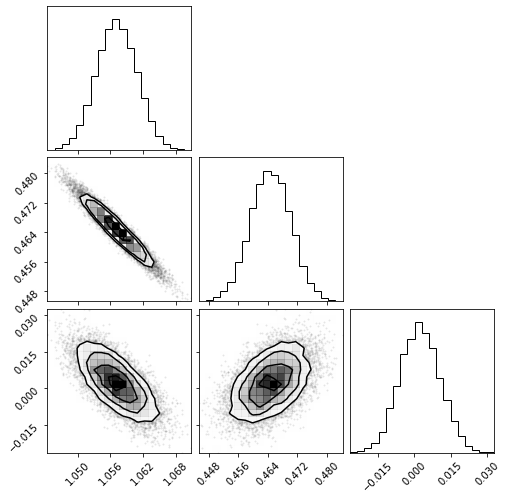

In [521]:
import corner

corner.corner(post_lens_samples, truths=[1.3, 0.3, -0.15]);

In [522]:
from matplotlib.patches import Ellipse

def plot_fisher_single(i ,cov, mu, ax, lims) :
    nb=128
    sigma=np.sqrt(cov[i,i])
    x_arr=mu[i]-4*sigma+8*sigma*np.arange(nb)/(nb-1.)
    p_arr=np.exp(-(x_arr-mu[i])**2/(2*sigma**2))
    ax.plot(x_arr,p_arr)    
    ax.set_xlim(lims[0][i], lims[1][i])

def plot_fisher_two(i1, i2, cov, mu, ax, lims) :
    covar=np.zeros([2,2])
    covar[0,0]=cov[i1,i1]
    covar[0,1]=cov[i1,i2]
    covar[1,0]=cov[i2,i1]
    covar[1,1]=cov[i2,i2]
    sig0=np.sqrt(covar[0,0])
    sig1=np.sqrt(covar[1,1])

    w,v=np.linalg.eigh(covar)
    
    angle=180*np.arctan2(v[1,0],v[0,0])/np.pi
    a_1s=np.sqrt(2.3*w[0])
    b_1s=np.sqrt(2.3*w[1])
    a_2s=np.sqrt(6.17*w[0])
    b_2s=np.sqrt(6.17*w[1])

    centre=np.array([mu[i1],mu[i2]])
        
    ax.scatter(centre[0], centre[1])

    e_1s=Ellipse(xy=centre,width=2*a_1s,height=2*b_1s,angle=angle)
    e_2s=Ellipse(xy=centre,width=2*a_2s,height=2*b_2s,angle=angle)

    ax.add_artist(e_2s)
    ax.add_artist(e_1s)

    ax.set_xlim(lims[0][i1], lims[1][i1])
    ax.set_ylim(lims[0][i2], lims[1][i2])

def plot_fisher_all(mu, cov, lims): 
    n_params = len(mu)

    fig=plt.figure(figsize=(12, 12))
    plt.subplots_adjust(hspace=0, wspace=0)
    for i in np.arange(n_params):
        i_col=i
        for j in np.arange(n_params-i)+i :
            i_row=j
            iplot=i_col+n_params*i_row+1

            ax=fig.add_subplot(n_params,n_params,iplot)
            if i==j :
                plot_fisher_single(i, cov, mu, ax, lims)
            else :
                plot_fisher_two(i, j, cov, mu, ax, lims)

            if i_row!=n_params-1 :
                ax.get_xaxis().set_visible(False)

            if i_col!=0 :
                ax.get_yaxis().set_visible(False)

            if i_col==0 and i_row==0 :
                ax.get_yaxis().set_visible(False)
                
            ax.locator_params(nbins=6)

#     if n_params>1 : #Add labels in a separate plot
#         ax=fig.add_subplot(n_params,n_params,2)
#         ax.set_xlim([-1,1])
#         ax.set_ylim([-1,1])
#         for i in np.arange(len(labels)) :
#             ax.plot([-1,1],[-3,-3],color=lc[i],linestyle=ls[i],
#                     linewidth=lw[i],label=labels[i])
#         ax.legend(loc='upper left',frameon=False,fontsize=FS)
#         ax.axis('off')

#     if fname!="none" :
#         plt.savefig(fname,bbox_inches='tight')

    plt.show()

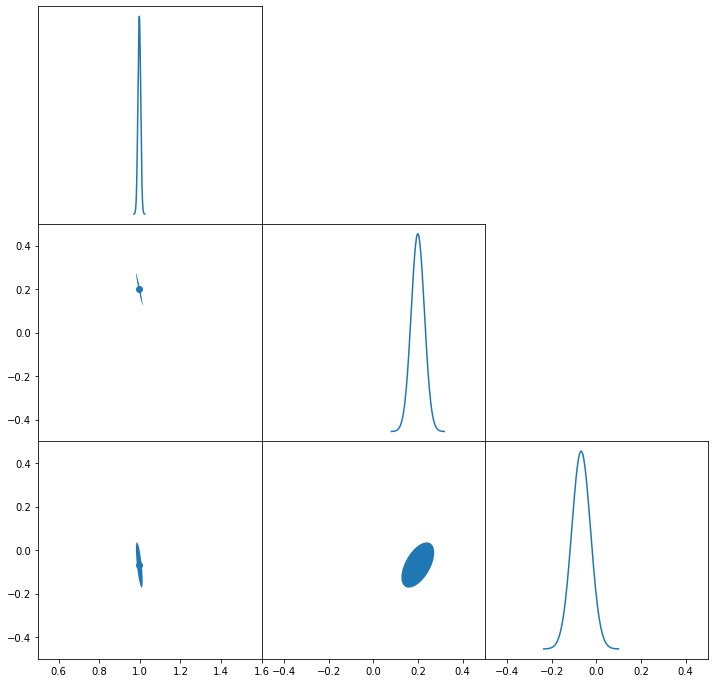

In [523]:
i = 3

chol = lct(hist['scale_tri_history'][i])

cov = np.dot(chol, chol.T)
mu = hist['loc_history'][i]

lims = [[0.5, -0.5, -0.5], [1.6, 0.5, 0.5]]

plot_fisher_all(mu, cov, lims)

In [524]:
hist["train_loss"][-1] / (n_xy * n_xy)

0.43021631240844727

(-10.0, 100.0)

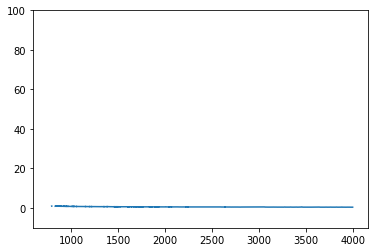

In [525]:
plt.plot(np.array(hist["train_loss"]) / (n_xy * n_xy))
plt.ylim(-10, 100)

In [526]:
# sigma = np.array(nn.softplus(hist["reconstructed_src_std"]))[-1, :]
# np.mean(sigma[sigma < 0.2])

In [527]:
# im = plt.imshow(np.sqrt(np.exp(np.array(hist["reconstructed_src_std"]))[-1, :]), cmap=cmap, vmax=0.1)
# cbar = plt.colorbar(im, ax=plt.gca())

In [528]:
from scipy.ndimage import gaussian_filter

In [529]:
from lensing_sim.profiles import MassProfileSIE
from lensing_sim.units import asctorad

x_d, y_d = MassProfileSIE(x_0=hst_param_dict["theta_x_0"] * lsi.D_l * asctorad,
                y_0=hst_param_dict["theta_y_0"] * lsi.D_l * asctorad,
                r_E=hst_param_dict["theta_E"] * lsi.D_l * asctorad,
                q=hst_param_dict["q"],
                ).deflection(lsi.x, lsi.y)

In [530]:
oob_cond = ((lsi.x + x_d) > np.max(lsi.x)) + ((lsi.x + x_d) < np.min(lsi.x)) + \
((lsi.y + y_d) > np.max(lsi.y)) + ((lsi.y + y_d) < np.min(lsi.y))

In [531]:
pixmax_cond = (im_source < 0.1 * im_source.max()) * oob_cond

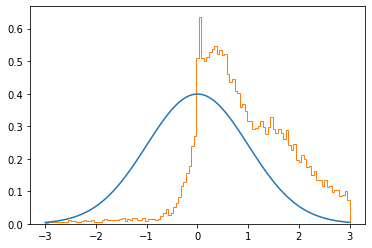

In [532]:
from scipy.stats import norm

pixmax_cond = (im_source < 0.5 * im_source.max()) * oob_cond

x_bins = np.linspace(-3, 3, 120)
z_sc = ((hist["reconstructed_src_mu"][-1][~pixmax_cond]) - im_source[~pixmax_cond]) / std_noise
# z_sc = ((hist["reconstructed_src_mu"][-1][~pixmax_cond]) - im_source[~pixmax_cond]) / ((hist["reconstructed_src_std"])[-1][~pixmax_cond])

plt.plot(x_bins, norm.pdf(x_bins))
plt.hist(z_sc, bins=x_bins, histtype='step', density=True);

In [533]:
# plt.imshow(hist["reconstructed_src_std"][-1], vmax=0.02)

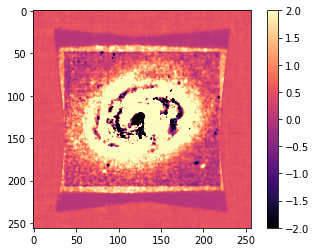

In [534]:
fig, ax = plt.subplots()
z_sc = ((hist["reconstructed_src_mu"][-1]) - im_source) / ((hist["reconstructed_src_std"])[-1])
im = ax.imshow(z_sc, cmap=cmap, vmin=-2, vmax=2)
cbar = fig.colorbar(im, ax=ax)

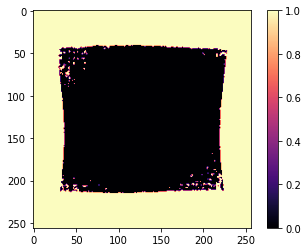

In [535]:
fig, ax = plt.subplots()
snr = ((hist["reconstructed_src_mu"][-1])) / ((hist["reconstructed_src_std"])[-1]) < 1
im = ax.imshow(snr, cmap=cmap, vmin=0, vmax=1)
cbar = fig.colorbar(im, ax=ax)

(-10.0, 100.0)

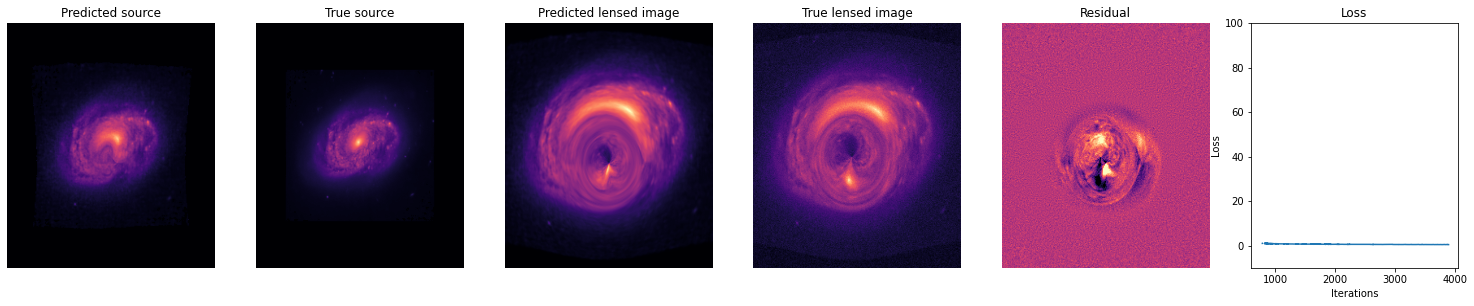

In [536]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(26, 4.5))

i = len(hist["reconstructed_src_mu"]) - 1

ax1.imshow((hist["reconstructed_src_mu"][i]) * ~snr, cmap=cmap, vmin=0, vmax=1, aspect="auto")
# ax1.imshow(gaussian_filter(hist["reconstructed_src_mu"][i] * ~oob_cond, sigma=0.025 / pixel_size, truncate=8.), cmap=cmap, vmin=0, vmax=1, aspect="auto")
ax1.set_title(f"Predicted source")
ax1.axis("off")
ax2.imshow(im_source * ~snr, cmap=cmap, vmin=0, vmax=1, aspect="auto")
ax2.set_title(f"True source")
ax2.axis("off")
ax3.imshow(hist["reconstructed_lens"][i], cmap=cmap, aspect="auto")
ax3.set_title(f"Predicted lensed image")
ax3.axis("off")
ax4.imshow(image_input[0].T, cmap=cmap, aspect="auto")
ax4.set_title(f"True lensed image")
ax4.axis("off")
# im = ax5.imshow((hist["reconstructed_src_mu"][i] - mnist_resized) / np.sqrt(np.exp(hist["reconstructed_src_std"][i])), cmap=cmap, vmin=-3, vmax=3)
im = ax5.imshow((hist["reconstructed_lens"][i] - image_input[0].T), cmap=cmap, aspect="auto", vmin=-0.2, vmax=0.2)
ax5.set_title(f"Residual")
ax5.axis("off")
ax6.plot(np.arange(plot_every * (i)), np.array(hist["train_loss"][:plot_every * (i)]) / (n_xy * n_xy))
ax6.set_title(f"Loss")
ax6.set_xlabel(f"Iterations")
ax6.set_ylabel(f"Loss")
ax6.set_ylim(-10, 100)

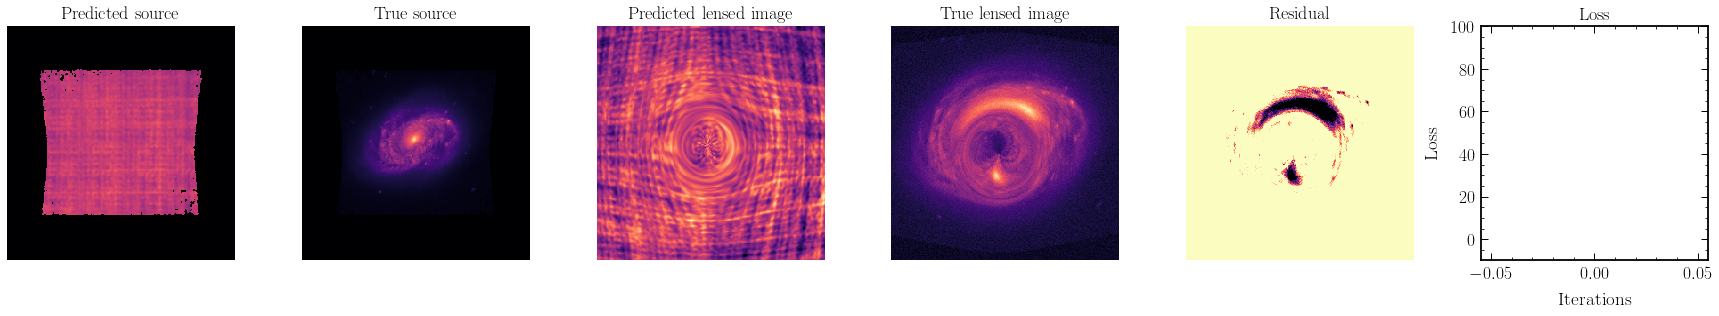

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

In [ ]:
from celluloid import Camera

epoch = -1

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 4.5))
camera = Camera(fig)

for i in range(len(hist["reconstructed_lens"])):
    ax1.imshow((hist["reconstructed_src_mu"][i]) * ~snr, cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax1.set_title(f"Predicted source")
    ax1.axis("off")
    ax2.imshow(im_source * ~snr, cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax2.set_title(f"True source")
    ax2.axis("off")
    ax3.imshow(hist["reconstructed_lens"][i], cmap=cmap, aspect="auto")
    ax3.set_title(f"Predicted lensed image")
    ax3.axis("off")
    ax4.imshow(image_input[0].T, cmap=cmap, aspect="auto")
    ax4.set_title(f"True lensed image")
    ax4.axis("off")
    # im = ax5.imshow((hist["reconstructed_src_mu"][i] - mnist_resized) / np.sqrt(np.exp(hist["reconstructed_src_std"][i])), cmap=cmap, vmin=-3, vmax=3)
    im = ax5.imshow((hist["reconstructed_lens"][i] - image_input[0].T), cmap=cmap, aspect="auto", vmin=-.1, vmax=.1)
    ax5.set_title(f"Residual")
    ax5.axis("off")
    ax6.plot(np.arange(plot_every * (i)), np.array(hist["train_loss"][:plot_every * (i)]) / (n_xy * n_xy), color=cols_default[0])
    ax6.set_title(f"Loss")
    ax6.set_xlabel(f"Iterations")
    ax6.set_ylabel(f"Loss")
    ax6.set_ylim(-10, 100)
    # cbar = fig.colorbar(im, ax=ax5)
    plt.tight_layout();
    plt.show()
    camera.snap()

In [ ]:
animation = camera.animate()
animation.save('render.gif', fps=7)

In [ ]:
# model_fn = lambda x: state.apply_fn({"params": state.params}, x)
# model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
# model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)
# plt.imshow(model_output[0])

## Truncated distribution tests

In [74]:
import distrax
import numpyro.distributions as dist

In [80]:
scale_tri = lct(hist['scale_tri_history'][-1])
loc = hist['loc_history'][-1]

In [85]:
samples = jnp.array(np.random.randn(64, 3))

In [86]:
mvn_distrax = distrax.MultivariateNormalTri(loc=loc, scale_tri=scale_tri)
mvn_distrax.log_prob(samples)

DeviceArray([-6.0259280e+06, -5.3568400e+07, -8.3345495e+06,
             -1.4498464e+06, -3.6387792e+07, -4.1472132e+07,
             -4.2495595e+06, -4.7814012e+07, -3.6825642e+06,
             -5.1385290e+06, -4.1710344e+05, -5.6285955e+06,
             -1.0531496e+08, -4.8025124e+07, -5.9387952e+07,
             -3.5017116e+07, -3.3382045e+06, -1.0218113e+07,
             -4.1894819e+05, -2.9783931e+05, -7.2920432e+07,
             -1.5640516e+06, -2.2449850e+07, -3.8683128e+07,
             -6.8908768e+07, -1.5772155e+04, -4.7271340e+04,
             -2.4883864e+07, -4.1050172e+07, -4.3201330e+06,
             -2.6462658e+06, -3.8874280e+07, -6.5455395e+06,
             -2.3915586e+07, -7.6137090e+06, -9.5561050e+06,
             -4.4547096e+07, -8.9718808e+07, -1.0877535e+05,
             -1.2727638e+07, -6.2422113e+04, -1.4106965e+08,
             -8.9284694e+05, -2.9639924e+07, -3.9878940e+07,
             -3.9498756e+07, -4.2572060e+07, -1.2964013e+05,
             -8.7652300e

In [412]:
mvn_numpyro = (dist.MultivariateNormal(loc=loc, scale_tril=scale_tri))
mvn_numpyro.log_prob(samples)

DeviceArray([-6.02592750e+06, -5.35684040e+07, -8.33454950e+06,
             -1.44984638e+06, -3.63877960e+07, -4.14721360e+07,
             -4.24955900e+06, -4.78140160e+07, -3.68256425e+06,
             -5.13852900e+06, -4.17103438e+05, -5.62859550e+06,
             -1.05314960e+08, -4.80251280e+07, -5.93879520e+07,
             -3.50171200e+07, -3.33820425e+06, -1.02181130e+07,
             -4.18948188e+05, -2.97839281e+05, -7.29204320e+07,
             -1.56405162e+06, -2.24498500e+07, -3.86831280e+07,
             -6.89087680e+07, -1.57721553e+04, -4.72713438e+04,
             -2.48838640e+07, -4.10501760e+07, -4.32013300e+06,
             -2.64626575e+06, -3.88742840e+07, -6.54553900e+06,
             -2.39155880e+07, -7.61370900e+06, -9.55610500e+06,
             -4.45470960e+07, -8.97188080e+07, -1.08775336e+05,
             -1.27276380e+07, -6.24221133e+04, -1.41069648e+08,
             -8.92846875e+05, -2.96399240e+07, -3.98789400e+07,
             -3.94987600e+07, -4.2572064

In [451]:
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors

lower_lims = jnp.array([0.5, -0.5, -0.5])
upper_lims = jnp.array([2, 0.5, 0.5])
softclip = tfb.SoftClip(lower_lims, upper_lims, hinge_softness=0.1)

samples = jnp.array(np.random.randn(64, 3))
softclip(samples)

DeviceArray([[ 0.50001407, -0.2096402 ,  0.49839297],
             [ 1.1766737 , -0.4942515 , -0.1625641 ],
             [ 0.5324974 , -0.49999386, -0.4992538 ],
             [ 1.58159   ,  0.4986143 ,  0.48801985],
             [ 0.5532832 , -0.49880815,  0.49999136],
             [ 0.5047885 , -0.49999702, -0.03500384],
             [ 0.500002  , -0.49919266,  0.03935122],
             [ 0.500003  ,  0.24199098, -0.44464433],
             [ 0.50008595, -0.22726583,  0.03412616],
             [ 0.5       , -0.49996287,  0.49895582],
             [ 1.2545247 ,  0.2860644 , -0.4283654 ],
             [ 0.5       , -0.46926206, -0.05419707],
             [ 0.5000011 ,  0.368539  , -0.4999962 ],
             [ 0.57634294,  0.15332517,  0.49951032],
             [ 0.5013591 ,  0.4999598 , -0.38222712],
             [ 0.5006037 ,  0.49999994,  0.49115878],
             [ 0.5002595 ,  0.17865965,  0.48016265],
             [ 0.5000125 ,  0.49999997, -0.4863906 ],
             [ 0.5       , -

In [402]:
# mvn_distrax_clip = distrax.Transformed(mvn_distrax, distrax.Block(softclip_bij, ndims=1))

In [403]:
# mvn_distrax_clip.log_prob(samples)

In [404]:
mvn_distrax_clip.sample(seed=key, sample_shape=(64,))

DeviceArray([[4.6445246, 2.3309846, 1.0687122],
             [4.6406975, 2.3304577, 1.1094875],
             [4.6407776, 2.341373 , 1.0607104],
             [4.6397123, 2.3356075, 1.092042 ],
             [4.6351995, 2.350822 , 1.0728807],
             [4.637741 , 2.3431497, 1.077826 ],
             [4.632428 , 2.343979 , 1.114294 ],
             [4.6439266, 2.328782 , 1.0795135],
             [4.6348724, 2.3387208, 1.1174693],
             [4.6433372, 2.3419385, 1.0419636],
             [4.626217 , 2.3594747, 1.1122727],
             [4.6425095, 2.3335338, 1.0778842],
             [4.6318874, 2.3525724, 1.0966387],
             [4.638152 , 2.3436694, 1.0783825],
             [4.647979 , 2.3242846, 1.0581717],
             [4.64664  , 2.3187141, 1.0977612],
             [4.634139 , 2.344573 , 1.10705  ],
             [4.6349277, 2.3486924, 1.0860405],
             [4.625251 , 2.3570986, 1.1305366],
             [4.638033 , 2.3394551, 1.0919714],
             [4.641038 , 2.329206 , 1.10

In [294]:
mvn_distrax.sample(seed=key, sample_shape=(64,))

DeviceArray([[ 1.3001838 ,  0.30450764, -0.15715472],
             [ 1.2981172 ,  0.30431142, -0.14224389],
             [ 1.2981603 ,  0.3083746 , -0.16008256],
             [ 1.2975858 ,  0.30622825, -0.14862137],
             [ 1.2951531 ,  0.31189376, -0.15562956],
             [ 1.2965224 ,  0.30903617, -0.1538205 ],
             [ 1.2936608 ,  0.30934495, -0.14048712],
             [ 1.2998607 ,  0.3036881 , -0.15320309],
             [ 1.2949768 ,  0.30738708, -0.13932686],
             [ 1.2995424 ,  0.30858514, -0.16694535],
             [ 1.2903206 ,  0.31511813, -0.1412258 ],
             [ 1.2990953 ,  0.30545643, -0.15379913],
             [ 1.29337   ,  0.3125461 , -0.14694054],
             [ 1.2967439 ,  0.30922973, -0.15361685],
             [ 1.3020506 ,  0.30201468, -0.16101168],
             [ 1.3013263 ,  0.299943  , -0.14653026],
             [ 1.2945817 ,  0.30956617, -0.14313482],
             [ 1.2950064 ,  0.31110036, -0.15081611],
             [ 1.2898022 ,  